# Gradient Estimation in 1-Step Navigation MDP

## Modeling 1-step transition and reward

<img src="files/img/1-step-Navigation.png" width="50%">
$$
\begin{equation}
\bar{a}_{t+1} = \pi_{\theta}(s_t)
\end{equation}
$$

$$
\begin{equation}
\alpha \sim \mathcal{N}(0, \sigma(\Vert \bar{a}_{t+1} \Vert))
\end{equation}
$$

$$
\begin{equation}
a_{t+1} = R(\alpha) \cdot \bar{a}_{t+1} = R(\alpha) = \begin{bmatrix}
\cos{\alpha} & -\sin{\alpha} \\
\sin{\alpha} & \cos{\alpha}
\end{bmatrix} \cdot \bar{a}_{t+1}
\end{equation}
$$

$$
\begin{equation}
s_{t+1} = s_t + a_{t+1}
\end{equation}
$$

$$
\begin{equation}
r_{t+1} = -\Vert g - s_{t+1} \Vert
\end{equation}
$$

## Noisy Direction

$$
\begin{equation}
\sigma = \min \left \{ \sigma_{\text{min}}, \frac{\sigma_{\text{max}}}{\sqrt{2}} \Vert \bar{a}_{t+1} \Vert \right \}
\end{equation}
$$

$$
\sigma_{\text{min}} = \frac{2\pi}{360^o}\alpha_{\text{min}},~~\sigma_{\text{max}} = \frac{2\pi}{360^o}\alpha_{\text{max}}
$$


### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import os
import time

import utils

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Hyperparameters

In [2]:
# domain parameters
grid = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'start': np.random.uniform(1.0, 9.0, size=(2,)),
    'goal':  np.random.uniform(1.0, 9.0, size=(2,))
}

# hyperparameters
epoch = 200
learning_rate = 0.001
batch_size = 10000
max_time = 1

# TF-MDP with SGD

In [3]:
from tf_mdp.mdp.models.navigation import Navigation
from tf_mdp.mdp.rnn import MDP_RNN
from tf_mdp.mdp.loss import MSE_loss_function
from tf_mdp.policy.network import PolicyNetwork
from tf_mdp.policy.optimizer import SGDPolicyOptimizer
from tf_mdp.policy.simulate import PolicySimulator

In [14]:
graph = tf.Graph()

# MDP model
mdp = Navigation(graph, grid)

# define policy network
layers = [mdp.state_size + 1, 1000, mdp.action_size]
policy = PolicyNetwork(graph, layers)

# RNN inputs
timesteps = utils.build_timesteps(batch_size, max_time)
initial_state = utils.build_initial_state(grid['start'][0], grid['start'][1], batch_size)

# unroll MDP model
rnn = MDP_RNN(mdp, policy, batch_size)
rewards, states, actions, log_probs, final_state = rnn.unroll(initial_state, timesteps)

# loss function
total, loss = MSE_loss_function(graph, rewards)

# optimizer
optimizer = SGDPolicyOptimizer(graph, learning_rate, loss, total)

# let's train the model!
path = os.path.abspath('logs/navigation/1-step/train/model.ckpt')
losses, saver, uptime = optimizer.minimize(epoch, path)

Epoch   199: loss = 5.9084000587463385
Done in 49.589536 sec.

Model saved in file: /Users/thiagopbueno/Projects/jupyter-notebooks/gradient-estimators/notebooks/logs/navigation/1-step/train/model.ckpt


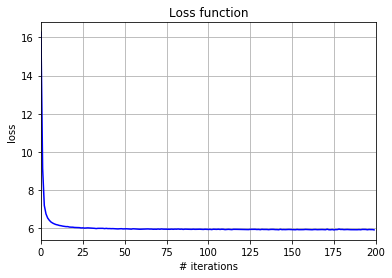

In [16]:
# visualize training
utils.plot_loss_function(losses, epoch)

INFO:tensorflow:Restoring parameters from /Users/thiagopbueno/Projects/jupyter-notebooks/gradient-estimators/notebooks/logs/navigation/1-step/train/model.ckpt

Mean:   [-0.98600447 -0.99835324]
Stddev: [  6.91413879e-06   1.36501121e-05]


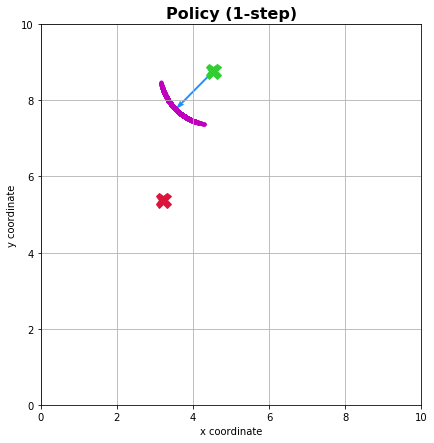

In [17]:
# simulations
simulation_batch_size = 10000
simulation_max_time = 1

s0 = utils.build_initial_state(grid['start'][0], grid['start'][1], simulation_batch_size)
timesteps = utils.build_timesteps(simulation_batch_size, simulation_max_time)

states_, actions_ = PolicySimulator(graph, path).run([states, actions], s0, timesteps)

states_ = np.reshape(states_,(simulation_batch_size, 2) )
actions_ = np.reshape(actions_,(simulation_batch_size, 2) )
print('\nMean:  ', np.mean(actions_, axis=0))
print('Stddev:', np.std(actions_, axis=0))

a = np.mean(actions_, axis=0)

fig = plt.figure(figsize=(7, 7))
utils.plot_policy(grid, a, states_)

# TF-MDP with SGD and Likelihood Ratio

In [7]:
graph = tf.Graph()

# MDP model
mdp = Navigation(graph, grid)

# define policy network
layers = [mdp.state_size + 1, 20, 5, mdp.action_size]
policy = PolicyNetwork(graph, layers)

# RNN inputs
timesteps = utils.build_timesteps(batch_size, max_time)
initial_state = utils.build_initial_state(grid['start'][0], grid['start'][1], batch_size)

# unroll MDP model
rnn = MDP_RNN(mdp, policy, batch_size)
rewards, states, actions, log_probs, final_state = rnn.unroll(initial_state, timesteps)

# loss function
total, loss = MSE_loss_function(graph, rewards)

# likelihood ratio
stochastic_nodes = graph.get_collection('stochastic')
with graph.as_default():
    gradients = []
    # ...

# optimizer
optimizer = SGDPolicyOptimizer(graph, loss, total, learning_rate, gradients)


# let's train the model!
# path = os.path.abspath('logs/navigation/1-step/train/model.ckpt')
# losses, saver, uptime = optimizer.minimize(epoch, path)